In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.path as mpathrm 
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
import calfem.geometry as cfg
import calfem.mesh as cfm
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator, CubicSpline, interp1d, PchipInterpolator, RegularGridInterpolator
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter
import sys
import os
import json
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape, Concatenate
from tensorflow.keras.models import Model
from tqdm import tqdm
from codebase.general import *
from codebase.sinn_functions import *

In [2]:
# Get Training and Validation Datasets
sigma = 20
encoder_data_history_range = (-40,0+1,10)
file_path = r'datasets/4000.am'
data = []
slices_arr = [[slice(0,1001,1),slice(0,250,1),slice(250,500,1)]]
for i in range(len(slices_arr)):
    slices = slices_arr[i]
    data += loadData(file_path, np.arange(*encoder_data_history_range), gradsBC=True, slices=slices, sigma=sigma)
data_train = data
meshing_size = 0.1
data_train_remesh = [RemeshData(data[i],meshing_size) for i in range(0,len(data),100)]
slices_test = [slice(0,1001,1),slice(250,500,1),slice(250,500,1)]
data_test = loadData(file_path, np.arange(*encoder_data_history_range), gradsBC=True, slices=slices_test, sigma=sigma)
data_test_remesh = [RemeshData(data_test[i],meshing_size) for i in range(0,len(data_test),100)]
data_train = data[::30]

(1001, 250, 250, 2)


(1001, 250, 250, 2)


In [ ]:
@tf.function
def TrainStep(encoder, encoderB, decoder, B, optimizer, batchI, batchB, batchC, r, fd_l_weight, elliptc_weight):

    with tf.GradientTape() as enc_tape, tf.GradientTape() as encB_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as b_tape:
        A = GetA(B)
        lossI, loglossI = InteriorForwardPass(encoder, decoder, A, r, *batchI, fd_l_weight, elliptc_weight)
        lossB, loglossB = BoundaryForwardPass(encoder, encoderB, decoder, A, r, *batchB, fd_l_weight, elliptc_weight)
        lossC, loglossC = CornerForwardPass(encoder, encoderB, decoder, A, r, *batchC, fd_l_weight, elliptc_weight)
        loss = tf.concat([lossI,lossB,lossC],0)

    grads_enc = enc_tape.gradient(loss,encoder.trainable_variables)
    grads_encB = encB_tape.gradient(loss,encoderB.trainable_variables)
    grads_dec = dec_tape.gradient(loss,decoder.trainable_variables)
    grads_b = b_tape.gradient(loss,B)
    optimizer.apply_gradients(zip(grads_enc,encoder.trainable_variables))
    optimizer.apply_gradients(zip(grads_dec,decoder.trainable_variables))
    optimizer.apply_gradients(zip(grads_encB,encoderB.trainable_variables))
    optimizer.apply_gradients(zip([grads_b],[B]))

    return loglossI+loglossB+loglossC

def TrainModel(encoder, encoderB, decoder, B, optimizer, dataset, dataset_b, dataset_c, r, epochs, n_batches, hyperParams, history=None, data_test=None, data_train=None):
    fd_l_weight = hyperParams['fd_l_weight']
    elliptc_weight = hyperParams['elliptc_weight']
    distanceBE = np.array(hyperParams['distanceBE'])
    if history is None:
        history = GetEmptyHistory()
    history_epoch = np.zeros((n_batches,12))
    for epoch in range(epochs):
        for i, (batchI, batchB, batchC) in enumerate(zip(dataset,dataset_b,dataset_c)):
            logloss = TrainStep(encoder, encoderB, decoder, B, optimizer, batchI, batchB, batchC, r, fd_l_weight, elliptc_weight)
            history_epoch[i,:] = logloss
            print(f'epoch: {epoch+1}/{epochs}; batch: {i+1}/{n_batches}; loss: {history_epoch[:,0].mean():.4g}', end='\r')
        
        logloss = history_epoch.mean(0)
        history['loss'].append((logloss[0]+logloss[4]+logloss[8])/3)
        history['loss_i'].append(logloss[0])
        history['loss_b'].append(logloss[4])
        history['loss_c'].append(logloss[8])
        history['r_loss_i'].append(logloss[1])
        history['r_loss_b'].append(logloss[5])
        history['r_loss_c'].append(logloss[9])
        history['fd_l_loss_i'].append(logloss[2])
        history['fd_l_loss_b'].append(logloss[6])
        history['fd_l_loss_c'].append(logloss[10])
        history['elliptic_loss'].append(logloss[3])
        print(f'epoch: {epoch+1}/{epochs}; batch: {i+1}/{n_batches}; loss: {history_epoch[:,0].mean():.4g}', end='')

        if (data_test is not None) and ((epoch+1)%2 == 0):
            err_arr = np.zeros((len(data_test)))
            for i in range(len(data_test)):
                err_arr[i] = SINNsEvalErr(data_test[i],encoderB,decoder,B,r,distanceBE)
            history['err_test'].append(err_arr.mean())
            history['err_epoch'].append(len(history['loss'])-1)
            print(f'; err_test: {err_arr.mean():.4g}', end='')
            if (data_train is not None):
                err_arr_train = np.zeros((len(data_train)))
                for i in range(len(data_train)):
                    err_arr_train[i] = SINNsEvalErr(data_train[i],encoderB,decoder,B,r,distanceBE)
                history['err_train'].append(err_arr_train.mean())
                print(f'; err_train: {err_arr_train.mean():.4g}', end='')
            print()
        else:
            print('', end='\r')

    return history

# Get model
batch_size = [128,64,16]
n_batches = 500
n_epochs = 80
layers = [1024,1024,1024,1024]
d_Encoder = data_train[0]['interpSE'].nDims
d_BoundaryEncoder = data_train[0]['interpBS'][0].nDims
elSize = meshing_size

hyperParams = {'N_interiorEncoder': None, 'd_interiorEncoder': d_Encoder, 'layers_interiorEncoder': layers,
               'N_boundarEncoder': None, 'd_boundarEncoder': d_BoundaryEncoder, 'layers_boundarEncoder': layers,
               'N_decoderOut': None, 'd_decoderOut': 2, 'layers_decoder': layers[:2],
               'n_latent': 4, 'activation': 'relu', 'elSizeMax': [elSize,elSize,elSize], 'elSizeMin': [elSize-0.001,elSize-0.001,elSize-0.001], 'variableElSize': None,
                'nIE1': 1, 'nIE2': 4, 'kIE': 1.0, 'sizeIE': 0.6*elSize, 'typeIE': 'radial',
               'nBE': 4, 'kBE': 1.0, 'sizeBE': 0.2,
               'nD1': 0, 'nD2': 5,  'kD': 1.0, 'sizeD': 0.03, 'typeD': 'radial',
               'fd_l_weight': 0.3, 'elliptc_weight': 0,
               'encoder_data_history_range': encoder_data_history_range, 'meshing_size': meshing_size, 'batch_size': batch_size}

if hyperParams['typeIE'] == 'radial':
    nodesIE = GetRadialEncoderInputMask(hyperParams['nIE1'],hyperParams['nIE2'],k=hyperParams['kIE'],Esize=hyperParams['sizeIE'])
elif hyperParams['typeIE'] == 'square':
    nodesIE = GetSquareEncoderInputMask(hyperParams['nIE1'],k=hyperParams['kIE'],Esize=hyperParams['sizeIE'])
else:
    raise ValueError('typeIE must be either "radial" or "square"')

if hyperParams['typeD'] == 'radial':
    nodesD = GetRadialEncoderInputMask(hyperParams['nD1'],hyperParams['nD2'],k=hyperParams['kD'],Esize=hyperParams['sizeD'])
elif hyperParams['typeD'] == 'square':
    nodesD = GetSquareEncoderInputMask(hyperParams['nD1'],k=hyperParams['kD'],Esize=hyperParams['sizeD'])
else:
    raise ValueError('typeD must be either "radial" or "square"')

distanceBE = GetBoundaryEncoderInputMask(hyperParams['nBE'],k=hyperParams['kBE'],Esize=hyperParams['sizeBE'])
hyperParams['N_interiorEncoder'] = nodesIE.shape[0]
hyperParams['N_boundarEncoder'] = distanceBE.shape[0]
hyperParams['N_decoderOut'] = nodesD.shape[0]
hyperParams['nodesIE'] = nodesIE.tolist()
hyperParams['distanceBE'] = distanceBE.tolist()
hyperParams['nodesD'] = nodesD.tolist()

dataset = GetInteriorDatasetFixed(data_train[:], nodesIE, nodesD, batch_size=batch_size[0], n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'][0], elSizeMax=hyperParams['elSizeMax'][0], variableElSize=hyperParams['variableElSize'], buffer_size=10_000)
dataset_b = GetBoundaryDatasetFixed(data_train[:], nodesIE, distanceBE, nodesD, batch_size=batch_size[1], n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'][1], elSizeMax=hyperParams['elSizeMax'][1], elSizeBF=hyperParams['variableElSize'], buffer_size=10_000)
dataset_c = GetCornerDatasetFixed(data_train[:], nodesIE, distanceBE, nodesD, batch_size=batch_size[2], n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'][2], elSizeMax=hyperParams['elSizeMax'][2])

encoder,encoderB,decoder = GetModels(hyperParams)
P = tf.Variable(tf.constant(tf.eye(hyperParams['n_latent']*2)*0.01,dtype=tf.float32))
r = hyperParams['n_latent']
history = GetEmptyHistory()

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

# Train model
history = TrainModel(encoder, encoderB, decoder, P, optimizer, dataset, dataset_b, dataset_c, r, n_epochs, n_batches, hyperParams,history=history,data_test=data_test_remesh[:],data_train=data_train_remesh[:])

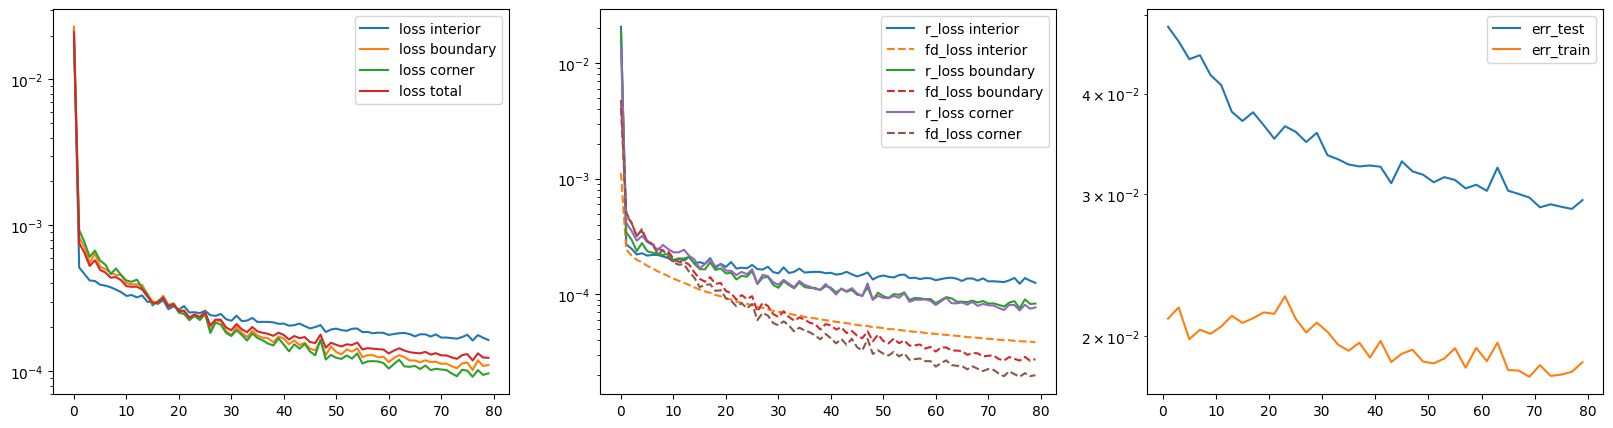

In [10]:
%matplotlib inline
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(history['loss_i'],label='loss interior')
plt.plot(history['loss_b'],label='loss boundary')
plt.plot(history['loss_c'],label='loss corner')
plt.plot(history['loss'],label='loss total')
plt.legend()
plt.gca().set_yscale('log')
plt.subplot(1,3,2)
plt.plot(history['r_loss_i'],label='r_loss interior')
plt.plot(np.array(history['fd_l_loss_i'])*hyperParams['fd_l_weight'],label='fd_loss interior', linestyle='--')
plt.plot(history['r_loss_b'],label='r_loss boundary')
plt.plot(np.array(history['fd_l_loss_b'])*hyperParams['fd_l_weight'],label='fd_loss boundary', linestyle='--')
plt.plot(history['r_loss_c'],label='r_loss corner')
plt.plot(np.array(history['fd_l_loss_c'])*hyperParams['fd_l_weight'],label='fd_loss corner', linestyle='--')
plt.legend()
plt.gca().set_yscale('log')
plt.subplot(1,3,3)
plt.plot(history['err_epoch'],history['err_test'],label='err_test')
plt.plot(history['err_epoch'],history['err_train'],label='err_train')
plt.legend()
plt.gca().set_yscale('log')

In [9]:
# Load a trained model
modelFolder = r'models/sinn_test_case_1'
encoder,encoderB,decoder,P,history,hyperParams = LoadModels(modelFolder)
r = hyperParams['n_latent']
nodesIE = np.array(hyperParams['nodesIE'])
nodesD = np.array(hyperParams['nodesD'])
distanceBE = np.array(hyperParams['distanceBE'])
meshing_size = hyperParams['meshing_size']

In [12]:
data_dynamic = []
# for i in tqdm(range(600,len(data),3)):
for i in tqdm(range(0,len(data_test),5)):
    data_i_remeshed = RemeshData(data_test[i],meshing_size)
    u_model,_  = SINNsPredict(data_i_remeshed,encoderB,decoder,P,r,distanceBE)
    data_i_remeshed['prediction'] = u_model
    data_i_remeshed['error'] = u_model - data_i_remeshed['solution']
    data_dynamic.append(data_i_remeshed)

100%|██████████| 193/193 [00:38<00:00,  4.99it/s]


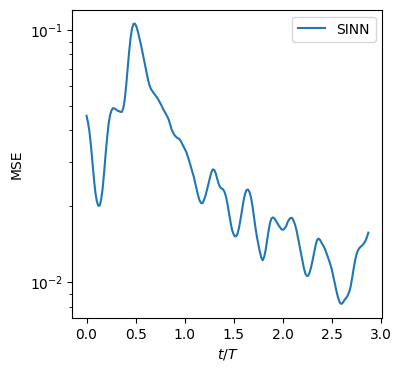

In [15]:
err = [np.mean(np.square(data_dynamic[i]['error'])) for i in range(len(data_dynamic))]
t = np.arange(0,len(data_test),5)*0.0029918255
plt.figure(figsize=(4,4),dpi=100)
plt.plot(t,err,'-',label='SINN')
plt.legend()
plt.xlabel('$t/T$')
plt.ylabel('MSE')
plt.gca().set_yscale('log')
plt.show()